In [67]:
import pandas as pd
import tensorflow as tf
import tensorflow.compat.v1 as tfc
from sklearn.utils.class_weight import compute_class_weight
from tensorflow import keras
from modeling import finetune_classifier

from modeling import stacking_from_csv, predict_from_csv
import pickle
from src import InputPipeline, make_finetune_curves

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Check GPU for tf

In [57]:
# Some GPU setup
# for documentation about using gpus refer to: https://www.tensorflow.org/install/pip#windows-wsl2

tf.keras.backend.clear_session()

device_name = tf.test.gpu_device_name()
if not device_name:
  raise SystemError('GPU device not found')
try:  # prevent a previous session from being alive
  sess.close() 
except:
  pass

tfc.enable_eager_execution()
gpu_options= tfc.GPUOptions(per_process_gpu_memory_fraction = 0.90)
sess = tfc.InteractiveSession(config=tfc.ConfigProto(gpu_options=gpu_options))

### Optional Stuff
- Here we compute classweights since the data is very imbalanced

In [58]:
train_df = pd.read_csv("../data/train_images_stratified.csv")

In [59]:
class_weights = compute_class_weight(class_weight = 'balanced', classes = train_df["label"].unique(), y=train_df["label"])
class_weights = dict(enumerate(class_weights))

## Configure Parameters

In [63]:
INPUT_SHAPE = (220, 220,3)

CONF = {
  "learning_rate": 0.0001,
  "batch_size": 18,
  "epochs": 5,
  "loss_function": "sparse_categorical_crossentropy",
  "metric": "sparse_categorical_accuracy",
}

## Make Input Pipelines

In [64]:
# Input pipeline for subspecies
sub_species_input_pipeline = InputPipeline(splits=(0.8,0.0,0.2), channels=3, batch_size=CONF["batch_size"], size=INPUT_SHAPE[:2])
# This has a stratified split
sub_species_input_pipeline.make_stratified_train_dataset(
  train_ds_path= "../data/train_ds_images_stratified.csv",
  val_ds_path="../data/val_ds_images_stratified.csv",
)


# Input pipeline for species
species_input_pipeline = InputPipeline(splits=(0.85,0.0,0.15), channels=3, batch_size=CONF["batch_size"], size=INPUT_SHAPE[:2])
species_input_pipeline.make_train_datasets(directory="../data/train_images/species_classify")  # This doesnt have a stratified split


Datasets populated!
Found 43186 files belonging to 70 classes.
Using 36709 files for training.
Using 6477 files for validation.
Datasets populated!


# Finetuning our models
## Species

In [65]:
finetune_classifier(
    model_path="../classifiers/species_effnet",
    configuration=CONF,
    train_dataset=sub_species_input_pipeline.train_dataset,
    validation_dataset=sub_species_input_pipeline.validation_dataset,
    class_weights=class_weights
                    )

Folder '../classifiers/' already exists.
Folder '../classifiers/trainHistoryDict' already exists.
Epoch 1/5
1286/1286 [==============================] - 400s 294ms/step - loss: 2.5873 - sparse_categorical_accuracy: 0.5613 - val_loss: 1.6349 - val_sparse_categorical_accuracy: 0.7948 - lr: 1.0000e-04
Epoch 2/5
1286/1286 [==============================] - 372s 289ms/step - loss: 1.9042 - sparse_categorical_accuracy: 0.7171 - val_loss: 1.4293 - val_sparse_categorical_accuracy: 0.8477 - lr: 1.0000e-04
Epoch 3/5
1286/1286 [==============================] - 372s 289ms/step - loss: 1.6076 - sparse_categorical_accuracy: 0.7935 - val_loss: 1.2744 - val_sparse_categorical_accuracy: 0.8786 - lr: 1.0000e-04
Epoch 4/5
1286/1286 [==============================] - 373s 290ms/step - loss: 1.3871 - sparse_categorical_accuracy: 0.8481 - val_loss: 1.1603 - val_sparse_categorical_accuracy: 0.9001 - lr: 1.0000e-04
Epoch 5/5
1286/1286 [==============================] - 373s 290ms/step - loss: 1.2381 - sparse

INFO:tensorflow:Assets written to: ../classifiers/species_effnet_tuned\assets


INFO:tensorflow:Assets written to: ../classifiers/species_effnet_tuned\assets


Model saved the tuned model under: ../classifiers/species_effnet_tuned


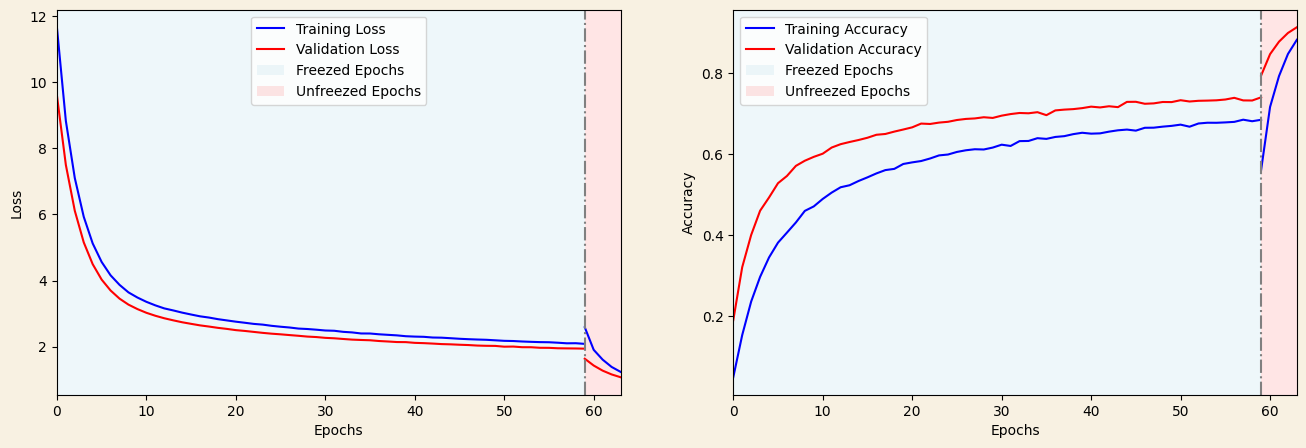

In [68]:
with open("../classifiers/trainHistoryDict/species_effnet.pkl", "rb") as file:
    last_hist = pickle.load(file)
with open("../classifiers/trainHistoryDict/species_effnet_tuned.pkl", "rb") as file:
    first_hist = pickle.load(file)

make_finetune_curves(first_hist,last_hist)

In [ ]:
predict_from_csv(
  classifier="../classifiers/species_effnet_tuned",
  dataset="../data/test_images_path.csv",
  path="../data/test_images",
  size=INPUT_SHAPE,
)

predicting:   7%|▋         | 282/4000 [00:48<09:59,  6.20it/s]

## Family Classifier

In [90]:
finetune_classifier(
    model_path="../classifiers/tuning_test",
    configuration=CONF,
    train_dataset=sub_species_input_pipeline.train_dataset,
    validation_dataset=sub_species_input_pipeline.validation_dataset,
    class_weights=class_weights
                    )